In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import QTable, Table, Column
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from statsmodels.tsa.ar_model import AutoReg

## Predict the Pharmaceutical Stock Price with Google Trends Data
In this extension research, we want to combine Google Trends data to explore the impact of relevant search keywords on the stock price of the pharmaceutical industry. So we take five most well-known stocks from the pharmaceutical industry as our new dataset, trying to use Google Trends data to predict the stock price and explore the impact of public opinion on public health on the pharmaceutical industry.

This work concludes 3 parts:
1. Data description

2. Model Selection (This work is in another file called model_selection.ipynb)

3. Prediction and Comparison

### 1. Data Description
The dataset concludes:
1. Five pharmaceutical companies' weekly stock price from 01-11-2010 to 01-11-2020. They're GlaxoSmithKline, Johnson &Johnson, Merck & Company, Inc., Pfizer, Inc. and Sanofi. 

2. Three keywords data include vaccine, virus and flu in Google Trends from 01-12-2019 to 01-12-2020.

3. Two categories data include health and finance in Google Trends from 01-12-2019 to 01-12-2020.

In [2]:
# Load the data
GSK_2020 = pd.read_csv('data/GSK_2020.csv',index_col=0, parse_dates=True)
JNJ_2020 = pd.read_csv('data/JNJ_2020.csv',index_col=0, parse_dates=True)
MRK_2020 = pd.read_csv('data/MRK_2020.csv',index_col=0, parse_dates=True)
PFE_2020 = pd.read_csv('data/PFE_2020.csv',index_col=0, parse_dates=True)
SNY_2020 = pd.read_csv('data/SNY_2020.csv',index_col=0, parse_dates=True)

The Adj Close means Adjusted Closing Price. It amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance. You can find more details about this here: https://www.investopedia.com/terms/a/adjusted_closing_price.asp

In [3]:
# Add log value of price
GSK_2020['log_Adj_Close'] = np.log(GSK_2020['Adj Close'])
JNJ_2020['log_Adj_Close'] = np.log(JNJ_2020['Adj Close'])
MRK_2020['log_Adj_Close'] = np.log(MRK_2020['Adj Close'])
PFE_2020['log_Adj_Close'] = np.log(PFE_2020['Adj Close'])
SNY_2020['log_Adj_Close'] = np.log(SNY_2020['Adj Close'])

In [4]:
GSK_2020.head()

,Adj Close,Vaccine,Virus,Flu,Health,Fin,log_Adj_Close
Date,,,,,,,
2019-12-02,43.315044,15,2,16,60,80,3.768500
2019-12-09,43.762375,14,2,18,60,82,3.778774
2019-12-16,45.037754,13,2,20,60,85,3.807501
2019-12-23,45.009193,11,2,24,55,75,3.806867
2019-12-30,44.238262,12,2,24,57,80,3.789590


In [5]:
GSK_2020['log_Adj_Close'].describe()

count    53.000000
mean      3.675019
std       0.077762
min       3.471195
25%       3.619565
50%       3.678078
75%       3.711305
max       3.819475
Name: log_Adj_Close, dtype: float64

In [6]:
JNJ_2020['log_Adj_Close'].describe()

count    53.000000
mean      4.959115
std       0.049709
min       4.766108
25%       4.944871
50%       4.974524
75%       4.988709
max       5.022055
Name: log_Adj_Close, dtype: float64

In [7]:
MRK_2020['log_Adj_Close'].describe()

count    53.000000
mean      4.379463
std       0.056324
min       4.244707
25%       4.340313
50%       4.379024
75%       4.416557
max       4.485956
Name: log_Adj_Close, dtype: float64

In [8]:
PFE_2020['log_Adj_Close'].describe()

count    53.000000
mean      3.526807
std       0.070054
min       3.285174
25%       3.506145
50%       3.538669
75%       3.576340
max       3.645711
Name: log_Adj_Close, dtype: float64

In [9]:
SNY_2020['log_Adj_Close'].describe()

count    53.000000
mean      3.881070
std       0.069806
min       3.601681
25%       3.855664
50%       3.898532
75%       3.927503
max       3.975186
Name: log_Adj_Close, dtype: float64

Text(0, 0.5, 'Stock Price')

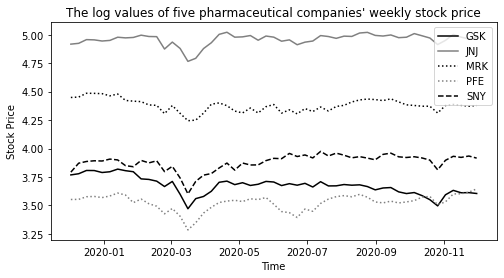

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(GSK_2020['log_Adj_Close'].index, GSK_2020['log_Adj_Close'], color = 'black', label = 'GSK')
plt.plot(GSK_2020['log_Adj_Close'].index, JNJ_2020['log_Adj_Close'], color = 'gray', label = 'JNJ')
plt.plot(GSK_2020['log_Adj_Close'].index, MRK_2020['log_Adj_Close'], color = 'black', label = 'MRK', linestyle=":")
plt.plot(GSK_2020['log_Adj_Close'].index, PFE_2020['log_Adj_Close'], color = 'gray', label = 'PFE', linestyle=":")
plt.plot(GSK_2020['log_Adj_Close'].index, SNY_2020['log_Adj_Close'], color = 'black', label = 'SNY', linestyle="--")
plt.legend()
plt.title('The log values of five pharmaceutical companies\' weekly stock price')
plt.xlabel('Time')
plt.ylabel('Stock Price')

Text(0, 0.5, 'Score')

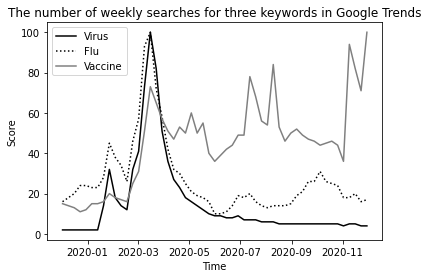

In [11]:
# Get the trends data - Keywords
trends = GSK_2020[['Virus', 'Flu', 'Vaccine']]
trends.head()
# Visualize the trends data
plt.plot(trends.index, trends['Virus'], color = 'black', label = 'Virus')
plt.plot(trends.index, trends['Flu'], color = 'black', label = 'Flu', linestyle=":")
plt.plot(trends.index, trends['Vaccine'], color = 'gray', label = 'Vaccine')
plt.legend()
plt.title('The number of weekly searches for three keywords in Google Trends')
plt.xlabel('Time')
plt.ylabel('Score')

Text(0, 0.5, 'Score')

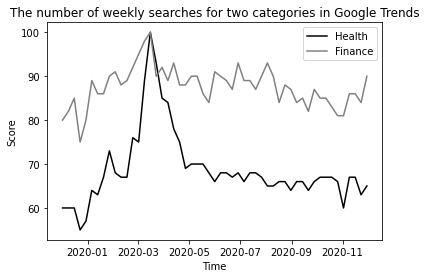

In [12]:
# Get the trends data - Categories
categories = GSK_2020[['Health','Fin']]
categories.head()
# Visualize the trends data
plt.plot(categories.index, categories['Health'], color = 'black', label = 'Health')
plt.plot(categories.index, categories['Fin'], color = 'gray', label = 'Finance')
plt.legend()
plt.title('The number of weekly searches for two categories in Google Trends')
plt.xlabel('Time')
plt.ylabel('Score')

### 2. Model Selection (See model_selection.ipynb)
After a test, we think the model: yt = b1 * y(t - 1) + et performs better. So we will use it to make predictions.

### 3. Prediction and Comparison

Now the data and model we need are all ready. Our first question is:

* What Google searchers are related to the pharmaceutical stock price?

To discover the relationship between these Google searchers and stock prices, we tried adding each keyword as an eigenvalue to the model. We also used two kinds of combination of these keywords as the eigenvalues.

In [13]:
# Get the actual value, i.e. the processed stock price data
GSK_actual_2020 = GSK_2020['log_Adj_Close'][2:]
JNJ_actual_2020 = JNJ_2020['log_Adj_Close'][2:]
MRK_actual_2020 = MRK_2020['log_Adj_Close'][2:]
PFE_actual_2020 = PFE_2020['log_Adj_Close'][2:]
SNY_actual_2020 = SNY_2020['log_Adj_Close'][2:]

Below you can find some helpful functions for building the model and making the out-of-sample prediction.

In [14]:
# Define a function that only uses actual stock prices to make predictions:
def base_prediction(stock):
    pred_base = []
    base_xtrain = []
    base_ytrain = []
    for i in range(len(stock)-2):
        base_xtrain.append(stock.iloc[i]['log_Adj_Close'])
        base_ytrain.append(stock.iloc[i+1]['log_Adj_Close'])
        # Reshape the list to array for model fitting
        temp_x = np.array(base_xtrain).reshape(-1,1)
        temp_y = np.array(base_ytrain).reshape(-1,1)
        # Train the model with the training data set
        model = LinearRegression().fit(temp_x, temp_y)
        # Implement the model function to predict the value
        yhat = np.dot(model.coef_, [stock.iloc[i+1]['log_Adj_Close']]) + model.intercept_
        # Store the prediction 
        pred_base.append(yhat[0])
        
    return pred_base

# Define a function that uses actual stock prices and a single keyword in Google Trends to make predictions:
def gt_prediction(stock, var):
    '''Single trends data prediction'''
    pred_trends = []
    trends_xtrain = []
    trends_ytrain = []
    for i in range(len(stock)-2):
        trends_xtrain.append([stock.iloc[i]['log_Adj_Close'],stock.iloc[i+1][var]])
        trends_ytrain.append(stock.iloc[i+1]['log_Adj_Close'])
        # Reshape the list to array for model fitting
        temp_x = np.array(trends_xtrain).reshape(-1,len(var)+1)
        temp_y = np.array(trends_ytrain).reshape(-1,1)
        # Train the model with the training data set
        model = LinearRegression().fit(temp_x, temp_y)
        # Implement the model function to predict the value
        yhat = np.dot(model.coef_, [stock.iloc[i+1]['log_Adj_Close'],stock.iloc[i+2][var]]) + model.intercept_
        # Store the prediction 
        pred_trends.append(yhat[0])
    return pred_trends

# Define a function that uses actual stock prices and the combination of all three keywords in Google Trends to
# make predictions:
def trends_prediction_p1(stock):
    '''Trends Prediction with a combination of Virus, Vaccine and Flu'''
    pred_trends = []
    trends_xtrain = []
    trends_ytrain = []
    for i in range(len(stock)-2):
        trends_xtrain.append([stock.iloc[i]['log_Adj_Close'],stock.iloc[i+1]['Virus'],stock.iloc[i+1]['Vaccine'],stock.iloc[i+1]['Flu']])
        trends_ytrain.append(stock.iloc[i+1]['log_Adj_Close'])
        # Reshape the list to array for model fitting
        temp_x = np.array(trends_xtrain).reshape(-1,4)
        temp_y = np.array(trends_ytrain).reshape(-1,1)
        # Train the model with the training data set
        model = LinearRegression().fit(temp_x, temp_y)
        # Implement the model function to predict the value
        yhat = np.dot(model.coef_, [stock.iloc[i+1]['log_Adj_Close'],stock.iloc[i+2]['Virus'],stock.iloc[i+2]['Vaccine'],stock.iloc[i+2]['Flu']]) + model.intercept_
        # Store the prediction 
        pred_trends.append(yhat[0])
    return pred_trends

# Define a function that uses actual stock prices and the combination of two keywords('Vaccine' and 'Flu') in Google
# Trends to make predictions:
def trends_prediction_p2(stock):
    '''Trends Prediction with a combination of Vaccine and Flu'''
    pred_trends = []
    trends_xtrain = []
    trends_ytrain = []
    for i in range(len(stock)-2):
        trends_xtrain.append([stock.iloc[i]['log_Adj_Close'],stock.iloc[i+1]['Vaccine'],stock.iloc[i+1]['Flu']])
        trends_ytrain.append(stock.iloc[i+1]['log_Adj_Close'])
        # Reshape the list to array for model fitting
        temp_x = np.array(trends_xtrain).reshape(-1,3)
        temp_y = np.array(trends_ytrain).reshape(-1,1)
        # Train the model with the training data set
        model = LinearRegression().fit(temp_x, temp_y)
        # Implement the model function to predict the value
        yhat = np.dot(model.coef_, [stock.iloc[i+1]['log_Adj_Close'],stock.iloc[i+2]['Vaccine'],stock.iloc[i+2]['Flu']]) + model.intercept_
        # Store the prediction 
        pred_trends.append(yhat[0])
    return pred_trends

In [15]:
# Base Prediction: only use actual stock prices to make predictions
GSK_base_2020 = base_prediction(GSK_2020)
JNJ_base_2020 = base_prediction(JNJ_2020)
MRK_base_2020 = base_prediction(MRK_2020)
PFE_base_2020 = base_prediction(PFE_2020)
SNY_base_2020 = base_prediction(SNY_2020)

In [16]:
# Report MAE for Base Prediction
MAE_GSK_base_2020 = MAE(GSK_base_2020,GSK_actual_2020)
MAE_PFE_base_2020 = MAE(PFE_base_2020,PFE_actual_2020)
MAE_JNJ_base_2020 = MAE(JNJ_base_2020,JNJ_actual_2020)
MAE_SNY_base_2020 = MAE(SNY_base_2020,SNY_actual_2020)
MAE_MRK_base_2020 = MAE(MRK_base_2020,MRK_actual_2020)

In [17]:
# Virus Prediction: use actual stock prices and the keyword 'Virus' in Google Trends to make predictions
var = ['Virus']
GSK_virus_2020 = gt_prediction(GSK_2020, var)
PFE_virus_2020 = gt_prediction(PFE_2020, var)
MRK_virus_2020 = gt_prediction(MRK_2020, var)
JNJ_virus_2020 = gt_prediction(JNJ_2020, var)
SNY_virus_2020 = gt_prediction(SNY_2020, var)

In [18]:
# Report MAE for Virus Prediction
MAE_GSK_virus_2020 = MAE(GSK_virus_2020,GSK_actual_2020)
MAE_PFE_virus_2020 = MAE(PFE_virus_2020,PFE_actual_2020)
MAE_SNY_virus_2020 = MAE(SNY_virus_2020,SNY_actual_2020)
MAE_JNJ_virus_2020 = MAE(JNJ_virus_2020,JNJ_actual_2020)
MAE_MRK_virus_2020 = MAE(MRK_virus_2020,MRK_actual_2020)

In [19]:
# Vaccine Prediction: use actual stock prices and the keyword 'Vaccine' in Google Trends to make predictions
var = ['Vaccine']
GSK_vaccine_2020 = gt_prediction(GSK_2020, var)
GSK_vaccine_2020 = gt_prediction(GSK_2020, var)
PFE_vaccine_2020 = gt_prediction(PFE_2020, var)
MRK_vaccine_2020 = gt_prediction(MRK_2020, var)
JNJ_vaccine_2020 = gt_prediction(JNJ_2020, var)
SNY_vaccine_2020 = gt_prediction(SNY_2020, var)

In [20]:
# Report MAE for Vaccine Prediction
MAE_GSK_vaccine_2020 = MAE(GSK_vaccine_2020,GSK_actual_2020)
MAE_PFE_vaccine_2020 = MAE(PFE_vaccine_2020,PFE_actual_2020)
MAE_SNY_vaccine_2020 = MAE(SNY_vaccine_2020,SNY_actual_2020)
MAE_JNJ_vaccine_2020 = MAE(JNJ_vaccine_2020,JNJ_actual_2020)
MAE_MRK_vaccine_2020 = MAE(MRK_vaccine_2020,MRK_actual_2020)

In [21]:
# Flu Prediction: use actual stock prices and the keyword 'Flu' in Google Trends to make predictions
var = ['Flu']
GSK_flu_2020 = gt_prediction(GSK_2020, var)
PFE_flu_2020 = gt_prediction(PFE_2020, var)
MRK_flu_2020 = gt_prediction(MRK_2020, var)
JNJ_flu_2020 = gt_prediction(JNJ_2020, var)
SNY_flu_2020 = gt_prediction(SNY_2020, var)

In [22]:
# Report MAE for Flu Prediction
MAE_GSK_flu_2020 = MAE(GSK_flu_2020,GSK_actual_2020)
MAE_PFE_flu_2020 = MAE(PFE_flu_2020,PFE_actual_2020)
MAE_SNY_flu_2020 = MAE(SNY_flu_2020,SNY_actual_2020)
MAE_JNJ_flu_2020 = MAE(JNJ_flu_2020,JNJ_actual_2020)
MAE_MRK_flu_2020 = MAE(MRK_flu_2020,MRK_actual_2020)

In [23]:
GSK_trends_2020 = trends_prediction_p1(GSK_2020)
JNJ_trends_2020 = trends_prediction_p1(JNJ_2020)
MRK_trends_2020 = trends_prediction_p1(MRK_2020)
PFE_trends_2020 = trends_prediction_p1(PFE_2020)
SNY_trends_2020 = trends_prediction_p1(SNY_2020)

In [24]:
# Trends Prediction for the recession period 1: use actual stock prices and the combination of all three keywords
# in Google Trends to make predictions
GSK_trends_2020_p1 = trends_prediction_p1(GSK_2020)
JNJ_trends_2020_p1 = trends_prediction_p1(JNJ_2020)
MRK_trends_2020_p1 = trends_prediction_p1(MRK_2020)
PFE_trends_2020_p1 = trends_prediction_p1(PFE_2020)
SNY_trends_2020_p1 = trends_prediction_p1(SNY_2020)

In [25]:
# Trends Prediction for the recession period 2: use actual stock prices and the combination of two keywords
# ('Vaccine' and 'Flu') in Google Trends to make predictions
GSK_trends_2020_p2 = trends_prediction_p2(GSK_2020)
JNJ_trends_2020_p2 = trends_prediction_p2(JNJ_2020)
MRK_trends_2020_p2 = trends_prediction_p2(MRK_2020)
PFE_trends_2020_p2 = trends_prediction_p2(PFE_2020)
SNY_trends_2020_p2 = trends_prediction_p2(SNY_2020)

In [26]:
# Report MAE for Trends Prediction
# (NOTE: Change the prediction values here to get the MAE of the two time periods!!)
MAE_GSK_trends_2020 = MAE(GSK_trends_2020,GSK_actual_2020)
MAE_PFE_trends_2020 = MAE(PFE_trends_2020,PFE_actual_2020)
MAE_SNY_trends_2020 = MAE(SNY_trends_2020,SNY_actual_2020)
MAE_JNJ_trends_2020 = MAE(JNJ_trends_2020,JNJ_actual_2020)
MAE_MRK_trends_2020 = MAE(MRK_trends_2020,MRK_actual_2020)

In [27]:
# Report absolute error for base prediction
AE_GSK_b = abs(GSK_base_2020 - GSK_actual_2020)
AE_JNJ_b = abs(JNJ_base_2020 - JNJ_actual_2020)
AE_MRK_b = abs(MRK_base_2020 - MRK_actual_2020)
AE_PFE_b = abs(PFE_base_2020 - PFE_actual_2020)
AE_SNY_b = abs(SNY_base_2020 - SNY_actual_2020)

In [28]:
# Report absolute error for 'virus' prediction
AE_GSK_t = abs(GSK_virus_2020 - GSK_actual_2020)
AE_JNJ_t = abs(JNJ_virus_2020 - JNJ_actual_2020)
AE_MRK_t = abs(MRK_virus_2020 - MRK_actual_2020)
AE_PFE_t = abs(PFE_virus_2020 - PFE_actual_2020)
AE_SNY_t = abs(SNY_virus_2020 - SNY_actual_2020)

In [29]:
# Report absolute error for 'vaccine' prediction
AE_GSK_t = abs(GSK_vaccine_2020 - GSK_actual_2020)
AE_JNJ_t = abs(JNJ_vaccine_2020 - JNJ_actual_2020)
AE_MRK_t = abs(MRK_vaccine_2020 - MRK_actual_2020)
AE_PFE_t = abs(PFE_vaccine_2020 - PFE_actual_2020)
AE_SNY_t = abs(SNY_vaccine_2020 - SNY_actual_2020)

In [30]:
# Report absolute error for 'flu' prediction
AE_GSK_t = abs(GSK_flu_2020 - GSK_actual_2020)
AE_JNJ_t = abs(JNJ_flu_2020 - JNJ_actual_2020)
AE_MRK_t = abs(MRK_flu_2020 - MRK_actual_2020)
AE_PFE_t = abs(PFE_flu_2020 - PFE_actual_2020)
AE_SNY_t = abs(SNY_flu_2020 - SNY_actual_2020)

In [31]:
# Report absolute error for trends prediction
# (NOTE: Change the prediction values here to get the AE of the two time periods!!)
AE_GSK_t = abs(GSK_trends_2020 - GSK_actual_2020)
AE_JNJ_t = abs(JNJ_trends_2020 - JNJ_actual_2020)
AE_MRK_t = abs(MRK_trends_2020 - MRK_actual_2020)
AE_PFE_t = abs(PFE_trends_2020 - PFE_actual_2020)
AE_SNY_t = abs(SNY_trends_2020 - SNY_actual_2020)

In [32]:
# Print the table of MAE
data_rows = (["Base MAE", round(MAE_GSK_base_2020, 5), round(MAE_JNJ_base_2020, 5), round(MAE_MRK_base_2020, 5),round(MAE_PFE_base_2020, 5),round(MAE_SNY_base_2020, 5)],
             ["Trends MAE", round(MAE_GSK_trends_2020, 5), round(MAE_JNJ_trends_2020, 5),round(MAE_MRK_trends_2020, 5),round(MAE_PFE_trends_2020, 5),round(MAE_SNY_trends_2020, 5)],
            ["Vaccine MAE", round(MAE_GSK_vaccine_2020, 5), round(MAE_JNJ_vaccine_2020, 5),round(MAE_MRK_vaccine_2020, 5),round(MAE_PFE_vaccine_2020, 5),round(MAE_SNY_vaccine_2020, 5)],
            ["Virus MAE", round(MAE_GSK_virus_2020, 5), round(MAE_JNJ_virus_2020, 5),round(MAE_MRK_virus_2020, 5),round(MAE_PFE_virus_2020, 5),round(MAE_SNY_virus_2020, 5)],
            ["Flu MAE", round(MAE_GSK_flu_2020, 5), round(MAE_JNJ_flu_2020, 5),round(MAE_MRK_flu_2020, 5),round(MAE_PFE_flu_2020, 5),round(MAE_SNY_flu_2020, 5)])
t1 = Table(rows=data_rows, names=('MAE Type', 'GSK', 'JNJ', 'MRK', 'PFE', 'SNY'))
#print(' Behavio of MAE around Turning Points - Period 1')
print(t1)

  MAE Type    GSK     JNJ     MRK     PFE     SNY  
----------- ------- ------- ------- ------- -------
   Base MAE 0.03423 0.02968 0.03699 0.04745  0.0339
 Trends MAE 0.03773 0.03284 0.03726 0.03565 0.02932
Vaccine MAE 0.03794  0.0348 0.03398 0.04127 0.03805
  Virus MAE 0.03766 0.02736 0.03462 0.04155 0.02609
    Flu MAE 0.03852 0.02927  0.0325 0.03521   0.027


We find that

* The combination of 'virus' and 'vaccine' works well for PFE and SNY;
* 'Vaccine' works well for MRK and PFE;
* 'Virus' works well for about all the stock except GSK;
* 'Flu' works well for JNJ, MRK, PFE and SNY.

It seems that all trends variables perform well on PFE and do not perform well on GSK. For JNJ, there're only two keywords that can decrease the MAE. Hence, we want to look deeper in GSK and JNJ.

In [33]:
def plot(stock, actual, base, trends):
    plt.plot(stock.index[2:], actual, color='black', label='Actual')
    plt.plot(stock.index[2:], base, color='black', label='Base', linestyle=":")
    plt.plot(stock.index[2:], trends, color='gray', label='trends')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Stock Price')

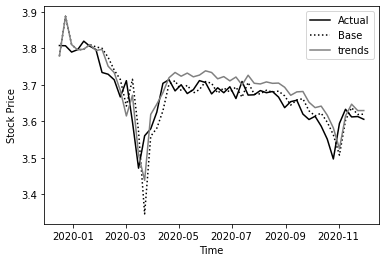

In [34]:
# the prediction of GSK
plot(GSK_2020, GSK_actual_2020, GSK_base_2020, GSK_virus_2020)

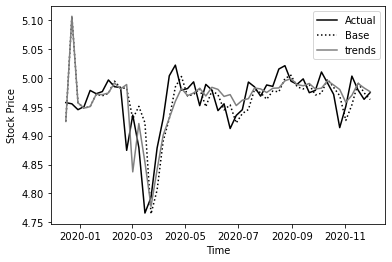

In [35]:
# the prediction of JNJ
plot(JNJ_2020, JNJ_actual_2020, JNJ_base_2020, JNJ_virus_2020)

It is obvious that all the stocks were encountered a recession period in 2020-03 and 2020-11. (You can find the stock price fluctuations of the other three stocks in data description.) So we want to discover whether the trends variables improve the prediction around the turning points.

In [36]:
# Get the stock prices in recession period 1
p1_GSK = GSK_actual_2020[(GSK_actual_2020.index>="2020/03/01")&(GSK_actual_2020.index<"2020/05/01")]
p1_JNJ = JNJ_actual_2020[(JNJ_actual_2020.index>="2020/03/01")&(JNJ_actual_2020.index<"2020/05/01")]
p1_MRK = MRK_actual_2020[(MRK_actual_2020.index>="2020/03/01")&(MRK_actual_2020.index<"2020/05/01")]
p1_PFE = PFE_actual_2020[(PFE_actual_2020.index>="2020/03/01")&(PFE_actual_2020.index<"2020/05/01")]
p1_SNY = SNY_actual_2020[(SNY_actual_2020.index>="2020/03/01")&(SNY_actual_2020.index<"2020/05/01")]

# Get the stock prices in recession period 2
p2_GSK = GSK_actual_2020[(GSK_actual_2020.index>="2020/09/15")&(GSK_actual_2020.index<"2020/11/01")]
p2_JNJ = JNJ_actual_2020[(JNJ_actual_2020.index>="2020/09/15")&(JNJ_actual_2020.index<"2020/11/01")]
p2_MRK = MRK_actual_2020[(MRK_actual_2020.index>="2020/09/15")&(MRK_actual_2020.index<"2020/11/01")]
p2_PFE = PFE_actual_2020[(PFE_actual_2020.index>="2020/09/15")&(PFE_actual_2020.index<"2020/11/01")]
p2_SNY = SNY_actual_2020[(SNY_actual_2020.index>="2020/09/15")&(SNY_actual_2020.index<"2020/11/01")]

In [37]:
start1 = GSK_actual_2020.index.get_loc(p1_GSK.index[0])-2
end1 = GSK_actual_2020.index.get_loc(p1_GSK.index[-1])-1

start2 = GSK_actual_2020.index.get_loc(p2_GSK.index[0])-2
end2 = GSK_actual_2020.index.get_loc(p2_GSK.index[-1])-1

Select the prediction data corresponding to each recession period.

In [38]:
p1_GSK_base = GSK_base_2020[start1 : end1]
p1_JNJ_base = JNJ_base_2020[start1 : end1]
p1_MRK_base = MRK_base_2020[start1 : end1]
p1_PFE_base = PFE_base_2020[start1 : end1]
p1_SNY_base = SNY_base_2020[start1 : end1]

p2_GSK_base = GSK_base_2020[start2 : end2]
p2_JNJ_base = JNJ_base_2020[start2 : end2]
p2_MRK_base = MRK_base_2020[start2 : end2]
p2_PFE_base = PFE_base_2020[start2 : end2]
p2_SNY_base = SNY_base_2020[start2 : end2]

In [39]:
p1_GSK_trends = GSK_virus_2020[start1 : end1]
p1_JNJ_trends = JNJ_virus_2020[start1 : end1]
p1_MRK_trends = MRK_virus_2020[start1 : end1]
p1_PFE_trends = PFE_virus_2020[start1 : end1]
p1_SNY_trends = SNY_virus_2020[start1 : end1]

p2_GSK_trends = GSK_virus_2020[start2 : end2]
p2_JNJ_trends = JNJ_virus_2020[start2 : end2]
p2_MRK_trends = MRK_virus_2020[start2 : end2]
p2_PFE_trends = PFE_virus_2020[start2 : end2]
p2_SNY_trends = SNY_virus_2020[start2 : end2]

In [40]:
p1_GSK_trends = GSK_vaccine_2020[start1 : end1]
p1_JNJ_trends = JNJ_vaccine_2020[start1 : end1]
p1_MRK_trends = MRK_vaccine_2020[start1 : end1]
p1_PFE_trends = PFE_vaccine_2020[start1 : end1]
p1_SNY_trends = SNY_vaccine_2020[start1 : end1]

p2_GSK_trends = GSK_vaccine_2020[start2 : end2]
p2_JNJ_trends = JNJ_vaccine_2020[start2 : end2]
p2_MRK_trends = MRK_vaccine_2020[start2 : end2]
p2_PFE_trends = PFE_vaccine_2020[start2 : end2]
p2_SNY_trends = SNY_vaccine_2020[start2 : end2]

In [41]:
p1_GSK_trends = GSK_flu_2020[start1 : end1]
p1_JNJ_trends = JNJ_flu_2020[start1 : end1]
p1_MRK_trends = MRK_flu_2020[start1 : end1]
p1_PFE_trends = PFE_flu_2020[start1 : end1]
p1_SNY_trends = SNY_flu_2020[start1 : end1]

p2_GSK_trends = GSK_flu_2020[start2 : end2]
p2_JNJ_trends = JNJ_flu_2020[start2 : end2]
p2_MRK_trends = MRK_flu_2020[start2 : end2]
p2_PFE_trends = PFE_flu_2020[start2 : end2]
p2_SNY_trends = SNY_flu_2020[start2 : end2]

In [42]:
p1_GSK_trends = GSK_trends_2020_p1[start1 : end1]
p1_JNJ_trends = JNJ_trends_2020_p1[start1 : end1]
p1_MRK_trends = MRK_trends_2020_p1[start1 : end1]
p1_PFE_trends = PFE_trends_2020_p1[start1 : end1]
p1_SNY_trends = SNY_trends_2020_p1[start1 : end1]

p2_GSK_trends = GSK_trends_2020_p2[start2 : end2]
p2_JNJ_trends = JNJ_trends_2020_p2[start2 : end2]
p2_MRK_trends = MRK_trends_2020_p2[start2 : end2]
p2_PFE_trends = PFE_trends_2020_p2[start2 : end2]
p2_SNY_trends = SNY_trends_2020_p2[start2 : end2]

In [43]:
# Report the MAE for recession period 1
MAE_GSK_b1 = MAE(p1_GSK, p1_GSK_base) 
MAE_GSK_t1 = MAE(p1_GSK, p1_GSK_trends)
MAE_JNJ_b1 = MAE(p1_JNJ, p1_JNJ_base) 
MAE_JNJ_t1 = MAE(p1_JNJ, p1_JNJ_trends)
MAE_MRK_b1 = MAE(p1_MRK, p1_MRK_base) 
MAE_MRK_t1 = MAE(p1_MRK, p1_MRK_trends)
MAE_PFE_b1 = MAE(p1_PFE, p1_PFE_base) 
MAE_PFE_t1 = MAE(p1_PFE, p1_PFE_trends)
MAE_SNY_b1 = MAE(p1_SNY, p1_SNY_base) 
MAE_SNY_t1 = MAE(p1_SNY, p1_SNY_trends)

# Report the MAE for recession period 2
MAE_GSK_b2 = MAE(p2_GSK, p2_GSK_base) 
MAE_GSK_t2 = MAE(p2_GSK, p2_GSK_trends)
MAE_JNJ_b2 = MAE(p2_JNJ, p2_JNJ_base) 
MAE_JNJ_t2 = MAE(p2_JNJ, p2_JNJ_trends)
MAE_MRK_b2 = MAE(p2_MRK, p2_MRK_base) 
MAE_MRK_t2 = MAE(p2_MRK, p2_MRK_trends)
MAE_PFE_b2 = MAE(p2_PFE, p2_PFE_base) 
MAE_PFE_t2 = MAE(p2_PFE, p2_PFE_trends)
MAE_SNY_b2 = MAE(p2_SNY, p2_SNY_base) 
MAE_SNY_t2 = MAE(p2_SNY, p2_SNY_trends)

In [44]:
# Print the table of MAE for period 1
data_rows = (["Base MAE", round(MAE_GSK_b1, 5), round(MAE_JNJ_b1, 5), round(MAE_MRK_b1, 5),round(MAE_PFE_b1, 5),round(MAE_SNY_b1, 5)],
             ["Trends MAE", round(MAE_GSK_t1, 5), round(MAE_JNJ_t1, 5),round(MAE_MRK_t1, 5),round(MAE_PFE_t1, 5),round(MAE_SNY_t1, 5)])
t1 = Table(rows=data_rows, names=('MAE Type', 'GSK', 'JNJ', 'MRK', 'PFE', 'SNY'))
print(' Behavio of MAE around Turning Points - Period 1')
print(t1)

 Behavio of MAE around Turning Points - Period 1
 MAE Type    GSK     JNJ     MRK     PFE     SNY  
---------- ------- ------- ------- ------- -------
  Base MAE 0.12119 0.11749 0.07502 0.11998 0.11982
Trends MAE 0.10255 0.11597 0.07451 0.10765 0.10512


In [45]:
# Print the table of MAE for period 2
data_rows = (["Base MAE", round(MAE_GSK_b2, 5), round(MAE_JNJ_b2, 5), round(MAE_MRK_b2, 5),round(MAE_PFE_b2, 5),round(MAE_SNY_b2, 5)],
             ["Trends MAE", round(MAE_GSK_t2, 5), round(MAE_JNJ_t2, 5),round(MAE_MRK_t2, 5),round(MAE_PFE_t2, 5),round(MAE_SNY_t2, 5)])
t1 = Table(rows=data_rows, names=('MAE Type', 'GSK', 'JNJ', 'MRK', 'PFE', 'SNY'))
print(' Behavio of MAE around Turning Points - Period 2 - With only Vaccine and Flue')
print(t1)

 Behavio of MAE around Turning Points - Period 2 - With only Vaccine and Flue
 MAE Type    GSK     JNJ     MRK     PFE     SNY  
---------- ------- ------- ------- ------- -------
  Base MAE 0.05967  0.0235 0.03138 0.02679 0.03081
Trends MAE 0.07988 0.02424 0.02612 0.02754 0.02684


Visualize the difference of absolute error between base and trends prediction.

In [46]:
# Calculate the difference of absolute error between the base prediction and trends prediction
diff_AE_GSK = AE_GSK_b - AE_GSK_t
diff_AE_JNJ = AE_JNJ_b - AE_JNJ_t
diff_AE_MRK = AE_MRK_b - AE_MRK_t
diff_AE_PFE = AE_PFE_b - AE_PFE_t
diff_AE_SNY = AE_SNY_b - AE_SNY_t

<BarContainer object of 51 artists>

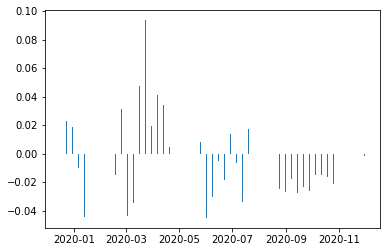

In [47]:
# GSK difference in AE
plt.bar(pd.to_datetime(diff_AE_GSK.index), diff_AE_GSK)

<BarContainer object of 51 artists>

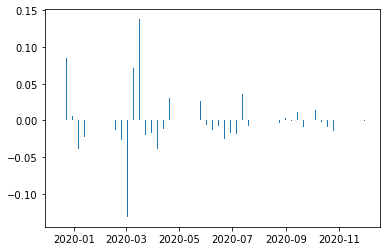

In [48]:
# JNJ difference in AE
plt.bar(pd.to_datetime(diff_AE_JNJ.index), diff_AE_JNJ)

<BarContainer object of 51 artists>

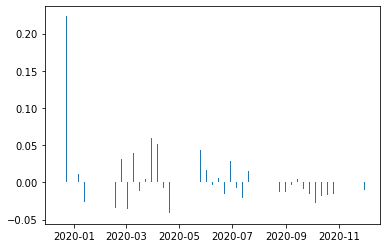

In [49]:
# MRK difference in AE
plt.bar(pd.to_datetime(diff_AE_MRK.index), diff_AE_MRK)

<BarContainer object of 51 artists>

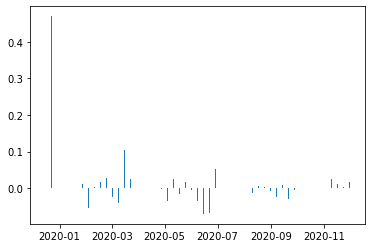

In [50]:
# PFE difference in AE
plt.bar(pd.to_datetime(diff_AE_PFE.index), diff_AE_PFE)

<BarContainer object of 51 artists>

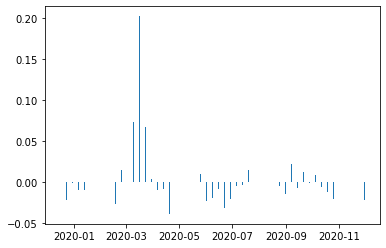

In [51]:
# SNY difference in AE
plt.bar(pd.to_datetime(diff_AE_SNY.index), diff_AE_SNY)

Through the report of MAE around the turning points and the bar plot, in which a positive value means base MAE is larger than trends MAE, we find that Google Trends variables perform well around the first turning point. However, the performance around the second turning point is not impressive.

Apart from the keywords, we're also interested in certain categories in Google Trends, which contain more amount of information and may have a better performance in prediction than keywords.

* What categories of Google Trends may improve the prediction?

After looking into the keyword seachers, we decide to see what categories of trends data may improve the prediction results. Here we choose 'Health' and 'Finance', which seems really related to the pharmaceutical stock price.

In [52]:
var = ['Health']
GSK_health_2020 = gt_prediction(GSK_2020, var)
PFE_health_2020 = gt_prediction(PFE_2020, var)
MRK_health_2020 = gt_prediction(MRK_2020, var)
JNJ_health_2020 = gt_prediction(JNJ_2020, var)
SNY_health_2020 = gt_prediction(SNY_2020, var)

In [53]:
var = ['Fin']
GSK_fin_2020 = gt_prediction(GSK_2020, var)
PFE_fin_2020 = gt_prediction(PFE_2020, var)
MRK_fin_2020 = gt_prediction(MRK_2020, var)
JNJ_fin_2020 = gt_prediction(JNJ_2020, var)
SNY_fin_2020 = gt_prediction(SNY_2020, var)

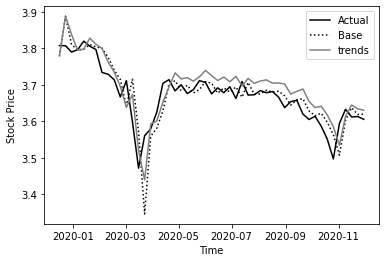

In [54]:
plot(GSK_2020, GSK_actual_2020, GSK_base_2020, GSK_health_2020)

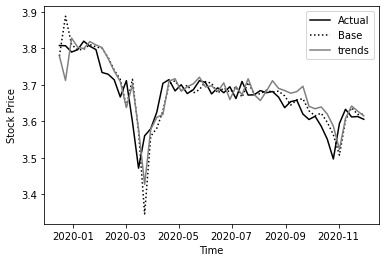

In [55]:
plot(GSK_2020, GSK_actual_2020, GSK_base_2020, GSK_fin_2020)

In [56]:
def trends_prediction_2(stock):
    pred_trends = []
    trends_xtrain = []
    trends_ytrain = []
    for i in range(len(stock)-2):
        trends_xtrain.append([stock.iloc[i]['log_Adj_Close'],stock.iloc[i+1]['Health'],stock.iloc[i+1]['Fin']])
        trends_ytrain.append(stock.iloc[i+1]['log_Adj_Close'])
        # Reshape the list to array for model fitting
        temp_x = np.array(trends_xtrain).reshape(-1,3)
        temp_y = np.array(trends_ytrain).reshape(-1,1)
        # Train the model with the training data set
        model = LinearRegression().fit(temp_x, temp_y)
        # Implement the model function to predict the value
        yhat = np.dot(model.coef_, [stock.iloc[i+1]['log_Adj_Close'],stock.iloc[i+2]['Health'],stock.iloc[i+2]['Fin']]) + model.intercept_
        # Store the prediction 
        pred_trends.append(yhat[0])
    return pred_trends

In [57]:
# Make the trends prediction with categories data
GSK_fh_2020 = trends_prediction_2(GSK_2020)
PFE_fh_2020 = trends_prediction_2(PFE_2020)
MRK_fh_2020 = trends_prediction_2(MRK_2020)
JNJ_fh_2020 = trends_prediction_2(JNJ_2020)
SNY_fh_2020 = trends_prediction_2(SNY_2020)

In [58]:
# Print the table of MAE
data_rows = (["Base MAE", round(MAE(GSK_actual_2020,GSK_base_2020), 5), round(MAE(JNJ_actual_2020,JNJ_base_2020), 5), round(MAE(MRK_actual_2020,MRK_base_2020), 5),round(MAE_PFE_b2, 5),round(MAE(SNY_actual_2020,SNY_base_2020), 5)],
             ["Health MAE", round(MAE(GSK_actual_2020,GSK_health_2020), 5), round(MAE(JNJ_actual_2020,JNJ_health_2020), 5),round(MAE(MRK_actual_2020,MRK_health_2020), 5),round(MAE(PFE_actual_2020,PFE_health_2020), 5),round(MAE(SNY_actual_2020,SNY_health_2020), 5)],
            ["Fin MAE", round(MAE(GSK_actual_2020,GSK_fin_2020), 5), round(MAE(JNJ_actual_2020,JNJ_fin_2020), 5),round(MAE(MRK_actual_2020,MRK_fin_2020), 5),round(MAE(PFE_actual_2020,PFE_fin_2020), 5),round(MAE(SNY_actual_2020,SNY_fin_2020), 5)],
            ["Fin-Health MAE", round(MAE(GSK_actual_2020,GSK_fh_2020), 5), round(MAE(JNJ_actual_2020,JNJ_fh_2020), 5),round(MAE(MRK_actual_2020,MRK_fh_2020), 5),round(MAE(PFE_actual_2020,PFE_fh_2020), 5),round(MAE(SNY_actual_2020,SNY_fh_2020), 5)])
t1 = Table(rows=data_rows, names=('MAE Type', 'GSK', 'JNJ', 'MRK', 'PFE', 'SNY'))
print(' Behavio of MAE with Google catogoriy trends')
print(t1)

 Behavio of MAE with Google catogoriy trends
   MAE Type      GSK     JNJ     MRK     PFE     SNY  
-------------- ------- ------- ------- ------- -------
      Base MAE 0.03423 0.02968 0.03699 0.02679  0.0339
    Health MAE 0.03902 0.03035  0.0351 0.05146 0.03004
       Fin MAE 0.03736  0.0301 0.03578 0.03834 0.03388
Fin-Health MAE 0.04299 0.03234 0.03319 0.04018 0.03075


It can be seen that these categories of trends data can improve some of the prediction. However, they still do not perform well on the prediction of GSK. This may indicate that the factors affecting stock prices are complex, which may contain policy, finance and many other elements.